<a href="https://colab.research.google.com/github/kodikarthik21/CS6910---Fundamentals-of-Deep-Learning/blob/main/Assignment04/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment 4 - Training RBMs

>ME18B149 - Karthik S , EE18B125 - Aravint Annamalai



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Libraries and installing Wandb

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from numpy import exp
from math import log
import tensorflow as tf
numpy_rng = np.random.RandomState(1234)

In [ ]:
!pip install wandb

In [ ]:
!pip install bioinfokit

     |████████████████████████████████| 92kB 4.0MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.4-cp37-none-any.whl size=56008 sha256=7a4b41609dbbf57924e82e0f6da7f4d77ab99810441413a4f5cb2cc62863808c
  Stored in directory: /root/.cache/pip/wheels/43/cf/aa/4a4fe54a3edb663ee7bd9b245bd946506c8bd4b99f4ae00507
  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=2ef2f92bc0ee99a12794ad5be746a2cef72d1d0138b77cacdd1db2b1e0479fb4
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built bioinfokit adjustText


In [ ]:
import wandb
wandb.login()

True

#Fashion_MNIST dataset

##Read the csv files 

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Fashion_MNIST/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Fashion_MNIST/fashion-mnist_test.csv')

##Flattening the dataset + Making the entries binary
> Value is made 1 if greater than 127 , 0 otherwise



In [ ]:
train_data_df = train_df.drop('label', axis=1)
train_data_np = train_data_df.to_numpy()

#Making the data binary
train_bin = np.where(train_data_np > 127, 1, 0)

#Flattening the matrix into a vector
train_data = train_bin.reshape(train_bin.shape[0], 784)

#True outputs
train_labels = train_df['label']

#Train and Val data that will be passed through the RBM
train_data,val_data,train_labels,val_labels = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)

In [ ]:
test_data_df = test_df.drop('label', axis=1)
test_data_np = test_data_df.to_numpy()
test_bin = np.where(test_data_np > 127, 1, 0)
test_data = test_bin.reshape(test_bin.shape[0], 784)
test_labels = test_df['label']

#Simple Logistic Regression Model


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,log_loss
def train_test(x_train, y_train, x_test,y_test):

  logisticRegr = LogisticRegression(max_iter = 1000,multi_class='multinomial')
  logisticRegr.fit(x_train, y_train)

  # Obtaining max probability 
  y_pred = logisticRegr.predict(x_test)

  # Obtaining Predicted class
  pred = logisticRegr.predict_proba(x_test)
  
  loss = log_loss(y_test,pred)
  accuracy = accuracy_score(y_test, y_pred)
  return loss, accuracy

#RBM Training

In [ ]:
def sigmoid(x):
    return 1. / (1 + np.exp(-x))

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

## Initializing RBM and the required functions

In [ ]:
class RBM(object):
    def __init__(self, input=None, n_visible=2, n_hidden=3, W=None, c=None, b=None):
        
        if W is None:
            initial_W = np.random.randn(n_visible, n_hidden) * 0.01
            W = initial_W

        if c is None:
            c = np.random.randn(n_hidden) * 0.01  

        if b is None:
            b = np.random.randn(n_visible) * 0.01 

        self.n_visible = n_visible 
        self.n_hidden = n_hidden   
        self.input = input
        self.W = W
        self.c = c
        self.b = b

#-----------CONTRASTIVE DIVERGENCE VISUALIZATION FOR THE 6th QUESTION-----------
def contrastive_divergence_visualization(rbm, epoch, v, lr=0.1, k=1, input=None):
    if input is not None:
        rbm.input = input
    

    h_sig_initial, samp_h_initial = prob_hv(rbm,rbm.input)

    chain_start = samp_h_initial


    for step in range(k):
        if step == 0:
            sig_v, samp_v = prob_vh(rbm,samp_h_initial)
        else:
            sig_v, samp_v = prob_vh(rbm,samp_h)
        sig_h, samp_h = prob_hv(rbm,samp_v)
        if (step*epoch)%4 == 0:
            v.append(samp_v)

    rbm.W += lr * (np.matmul(rbm.input.T, h_sig_initial) - np.matmul(samp_v.T,sig_h))/rbm.input.shape[0]
    rbm.b += lr * np.mean(rbm.input - samp_v, axis=0)
    rbm.c += lr * np.mean(h_sig_initial - sig_h, axis=0)
    #------------RETURNS THE VISUAL REPRESENTATIONS TAKEN AT APPROPRIATE STEPS-
    return v

#-----------CONTRASTIVE DIVERGENCE TRAINING-------------------------------------
def contrastive_divergence(rbm, epoch, lr=0.1, k=1, input=None):
    if input is not None:
        rbm.input = input
    

    h_sig_initial, samp_h_initial = prob_hv(rbm,rbm.input)


    for step in range(k):
        if step == 0:
            sig_v, samp_v = prob_vh(rbm,samp_h_initial)
        else:
            sig_v, samp_v = prob_vh(rbm,samp_h)
        sig_h, samp_h = prob_hv(rbm,samp_v)

    rbm.W += lr * (np.matmul(rbm.input.T, h_sig_initial) - np.matmul(samp_v.T,sig_h))/rbm.input.shape[0]
    rbm.b += lr * np.mean(rbm.input - samp_v, axis=0)
    rbm.c += lr * np.mean(h_sig_initial - sig_h, axis=0)


#-----------------SAMPLING(H/V)-------------------------
def prob_hv(rbm, v):
    sig_h = sigmoid(np.dot(v, rbm.W) + rbm.c)
    samp_h = numpy_rng.binomial(size=sig_h.shape, n=1, p=sig_h)
    return [sig_h, samp_h]

#-----------------SAMPLING(V/H)-------------------------
def prob_vh(rbm, h):
    sig_v =  sigmoid(np.dot(h, rbm.W.T) + rbm.b)
    samp_v = numpy_rng.binomial(size=sig_v.shape, n=1, p=sig_v) 
    return [sig_v, samp_v]

#--------------- COMPUTE HIDDEN REPRESENTATION OF VALIDATION AND TEST DATA-----------
def get_hidden_reps(rbm, v,t):
    h_v = sigmoid(np.dot(v, rbm.W) + rbm.c)
    h_t = sigmoid(np.dot(t, rbm.W) + rbm.c)
    return h_v,h_t      

#---------------TRAIN THE RBM AND RETURN HIDDEN REPRESENTATIONS OF VALIDATION AND TEST DATA
def train_rbm(rbm,epoch, v,t,learning_rate=0.05, k = 1,):
    contrastive_divergence(rbm,epoch,lr=learning_rate,k=k)
    return get_hidden_reps(rbm,v,t)


#Wandb Sweep

In [ ]:
def swp():
  hyperparameter_defaults = dict(
    n_hidden=64,
    k = 5
  )

  wandb.init(project="Assignment-4", config=hyperparameter_defaults)
  config = wandb.config
  wandb.run.name = "{}_h_layers_{}_steps".format(config.n_hidden, config.k)
  n_visible=784

  # INITIALIZE RBM
  rbm = RBM(input=train_data, n_visible=n_visible, n_hidden=config.n_hidden)

  for epoch in range(25):

    # GET HIDDEN REPRESENTATIONS
    hidden_rep,hidden_rep_test= train_rbm(rbm,epoch, val_data,test_data,k=config.k)
    print('Training epoch: %d' %epoch)

    # TRAIN LOGISTIC REGRESSION MODEL USING val_data AND CALCULATE TEST LOSS AND ACCURACY
    loss, accuracy = train_test(hidden_rep, val_labels, hidden_rep_test,test_labels)
    print('Loss:{} Accuracy:{}'.format(loss,accuracy))

    # LOG THE ABOVE VALUES IN WANDB
    metrics = {'epoch':epoch, 'accuracy': accuracy, 'loss': loss}
    wandb.log(metrics)
  wandb.run.finish()

In [ ]:
sweep_config = {
  "name": "Sweep - CD",
  "method": "grid",
  "project": "Assignment-4",
  "metric":{
      "name":"val_accuracy",
      "goal":"maximize"
  },
  "parameters": {
        "n_hidden": {
            "values":[64,128,256]
        },
        "k": {
            "values":[1,5,10]
        }
    }
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: m5zqlxur
Sweep URL: https://wandb.ai/kodikarthik21/uncategorized/sweeps/m5zqlxur


In [ ]:
#wandb.agent('wwkcckco', swp)

# Best Model - Contrastive Divergence Visualization

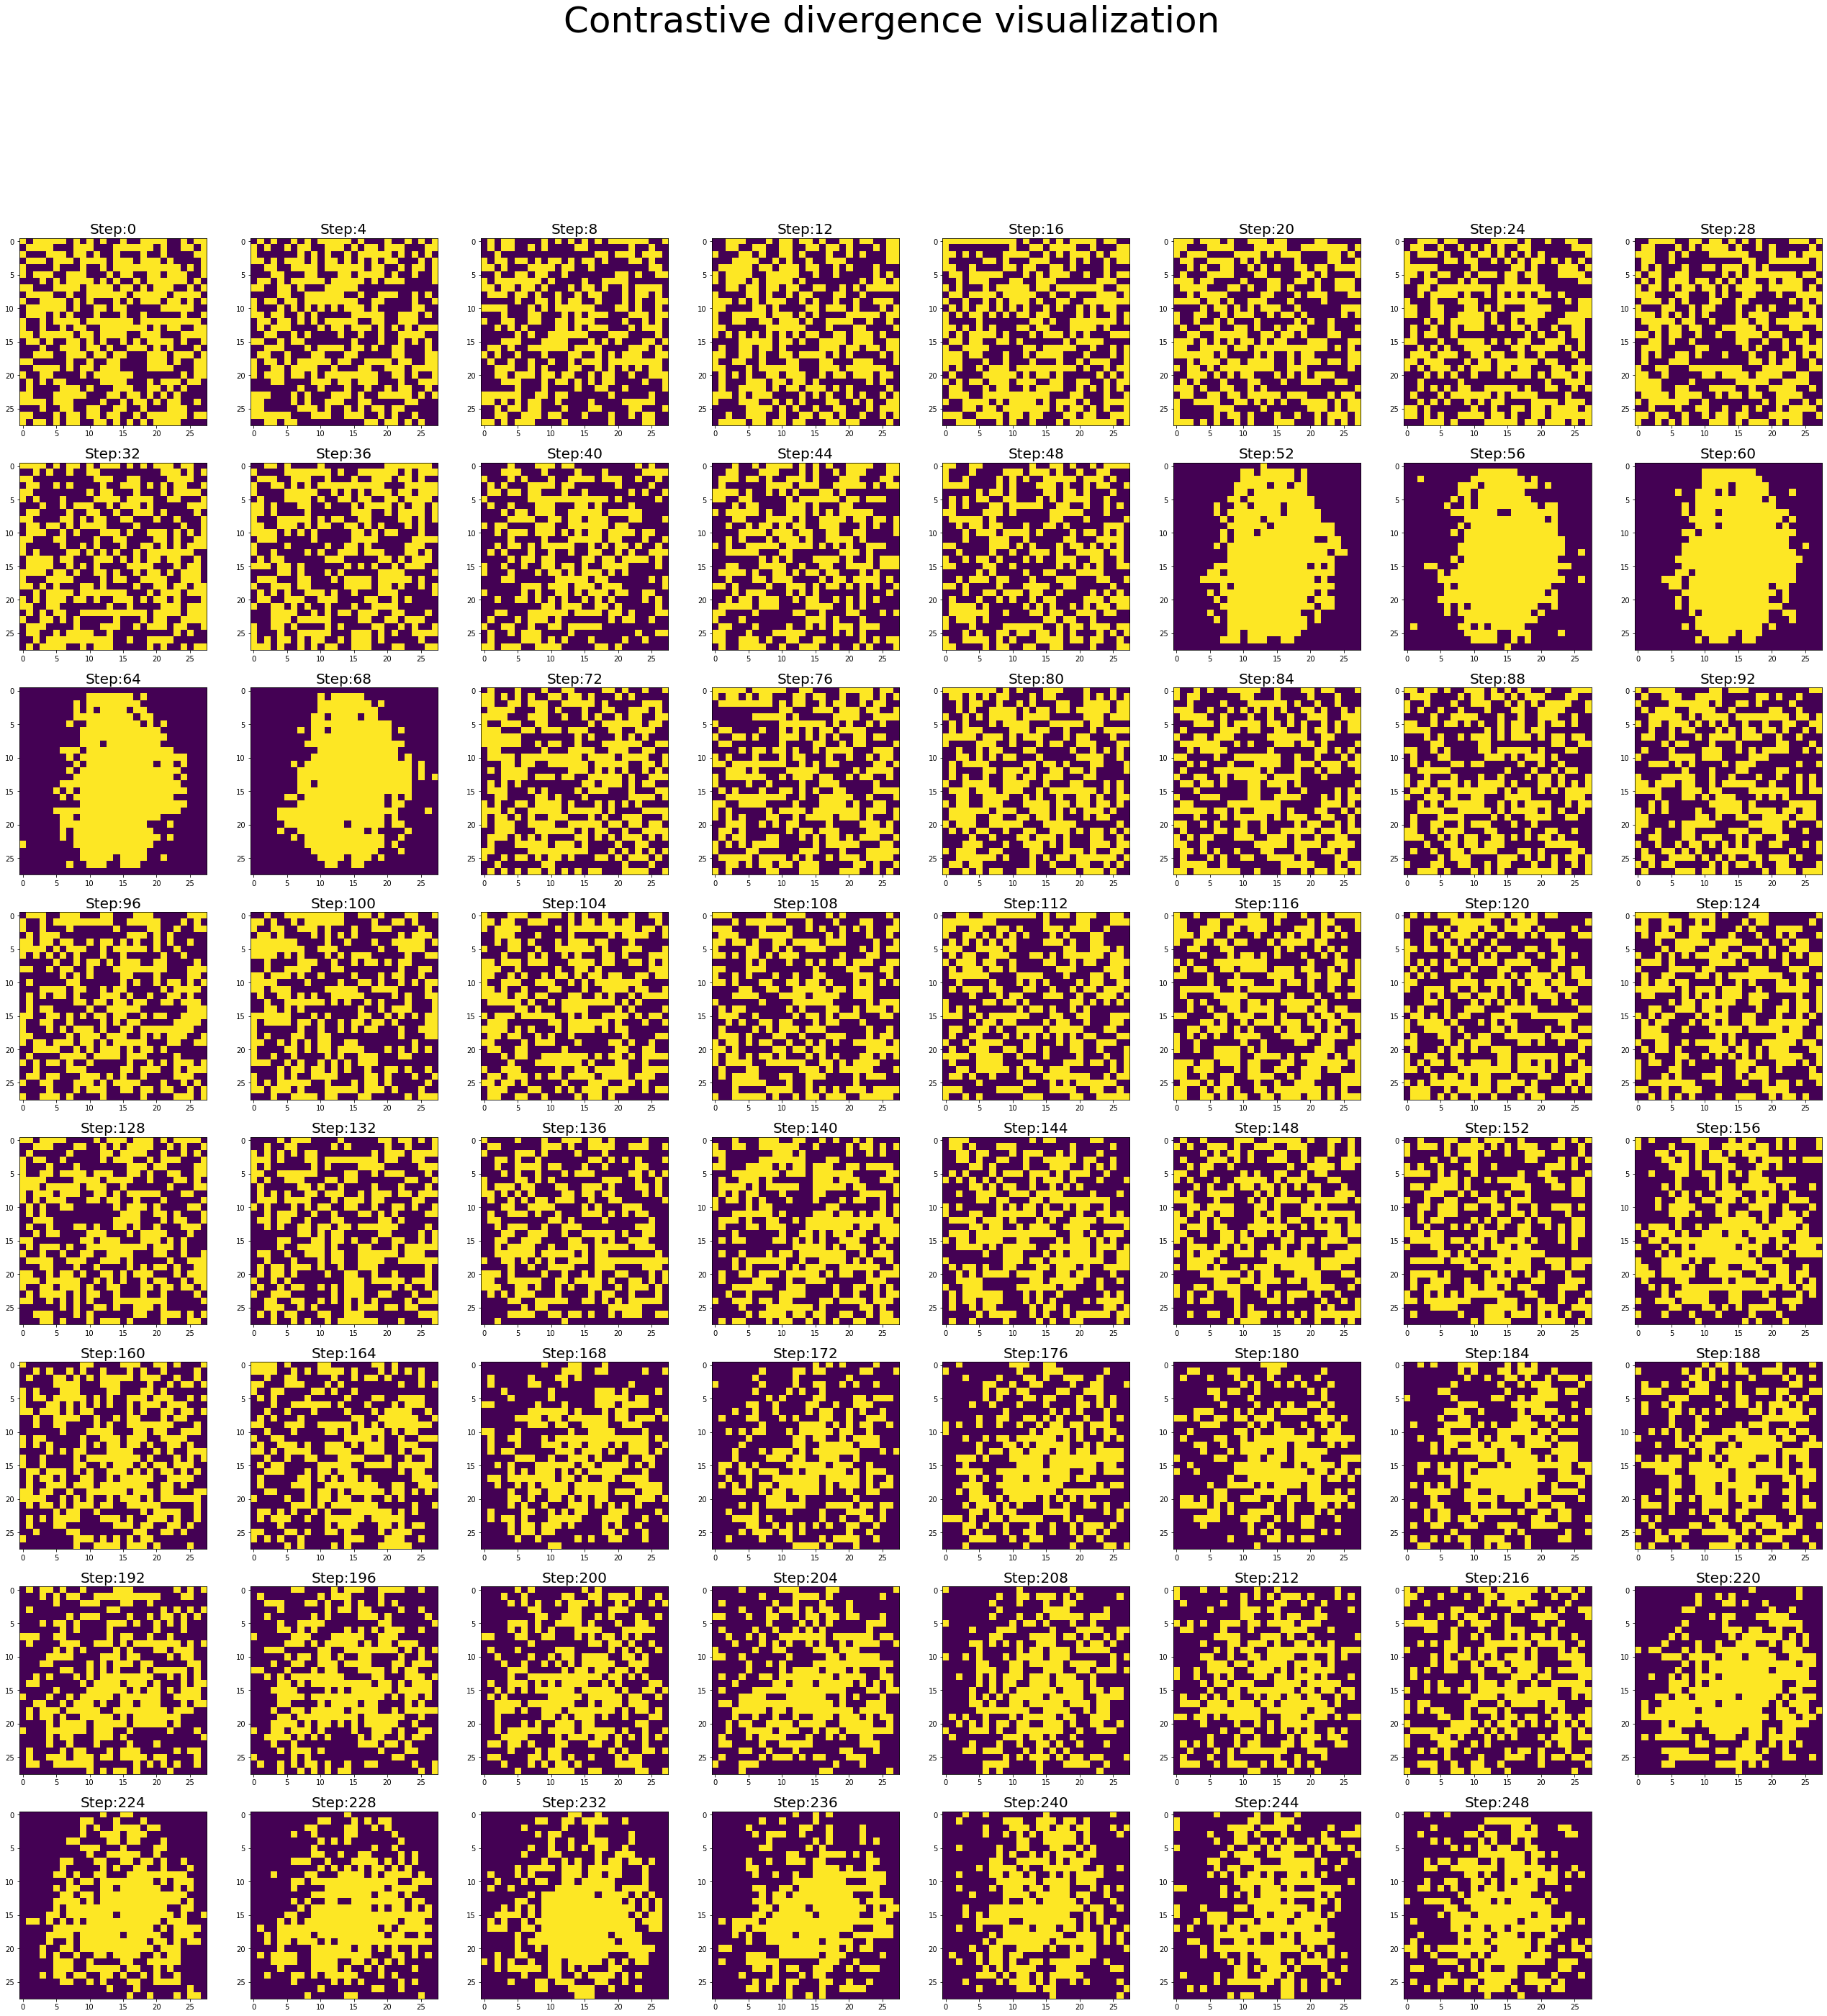

In [ ]:
rbm = RBM(input=train_data, n_visible=784, n_hidden=256)
wandb.init(project="Assignment-4")
wandb.run.name = "Best model"
vis = []
for epoch in range(25):
  print('Training epoch: %d' %epoch)

  # GET VISIBLE REPRESENTATION(v_i) AT REQUIRED STEPS
  vis = contrastive_divergence_visualization(rbm, epoch, vis ,k=10,input = val_data)
  print("Done")

plt.figure(figsize=(45, 45))
plt.suptitle("Contrastive divergence visualization",fontsize = 50)
for i in range(63):
  plt.subplot(8,8,i+1)

  #----CONVERT TO SQUARE AND PLOT
  plt.imshow(np.reshape(vis[i][2],(28,28)).astype("uint8"))
  plt.title("Step:{}".format(4*i),fontsize = 20)
  plt.show 

wandb.log({"Contrastive divergence visualization": wandb.Image(plt) })
wandb.run.finish()

#t-SNE for best CD model

In [ ]:
rbm = RBM(input=train_data, n_visible=784, n_hidden=256) #Best model configurations
wandb.init(project="Assignment-4")
wandb.run.name = "Best model"
for epoch in range(25):
  print('Training epoch: %d' %epoch)
  hidden_rep,hidden_rep_test= train_rbm(rbm,epoch, val_data,test_data,k=10) #training the best model and getting hidden representations
  print("Done")

In [ ]:
from sklearn.manifold import TSNE
X_reduced = TSNE(n_components=2).fit_transform(hidden_rep_test) #Dimensionality reduction of hidden representation to 2 dimensions

In [ ]:
from bioinfokit.visuz import cluster #library for plotting X_reduced

Running the below code will plot the t-SNE in a 2-D plane. The result will be saved as tsne_2d.png in your current directory. If you are running it in Colab, it will be present in the file explorer in the left hand side of the notebook

In [ ]:
color_class = test_labels.to_numpy()
cluster.tsneplot(score=X_reduced, colorlist=color_class, legendpos='upper right', legendanchor=(1.15, 1) )

In [ ]:
wandb.log({"t-SNE Visualization": wandb.Image("/content/tsne_2d.png")}) #logging the plot to wandb